In [1]:
from tifffile import imread
import os
from os.path import exists
import cv2
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import pandas as pd
from rich.progress import track

pd.options.mode.chained_assignment = None  # default='warn'

## Parameters and path

In [2]:
um_per_pixel = 0.117
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_D to organization_exclude hypothesis/FUS_SPT_PAINT"
os.chdir(folder_save)

fname = (
    "20230909-FUS488-50pM-100ms-473-nm-30-per_FOV-2-tracks-no5threshold_reformatted.csv"
)
df = pd.read_csv(fname)

line_color = "white"  # #00274C
scalebar_color = "white"

# color
color_condensate_edge = "#a7cced"
cmap_color_start = "black"
cmap_color_end = "#B9DBF4"
cmap_name = "dark2cyan"
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
    N=100,
)

## Construct PAINT image

In [3]:
scaling_factor = 1
um_per_pixel_PAINT = um_per_pixel / scaling_factor
xedges = np.arange((418 + 1) * scaling_factor)
yedges = np.arange((674 + 1) * scaling_factor)

img_PAINT, _, _ = np.histogram2d(
    x=df["x"] * scaling_factor,
    y=df["y"] * scaling_factor,
    bins=(xedges, yedges),
)
scalebar_length_um = 5
scalebar_length_pxl = scalebar_length_um * scaling_factor / um_per_pixel

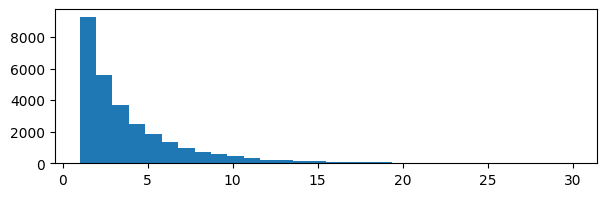

In [4]:
# Plot distribution as reference
plt.figure(figsize=(7, 2))
plt.hist(img_PAINT.reshape(-1), bins=30, range=(1, 30))
plt.show()

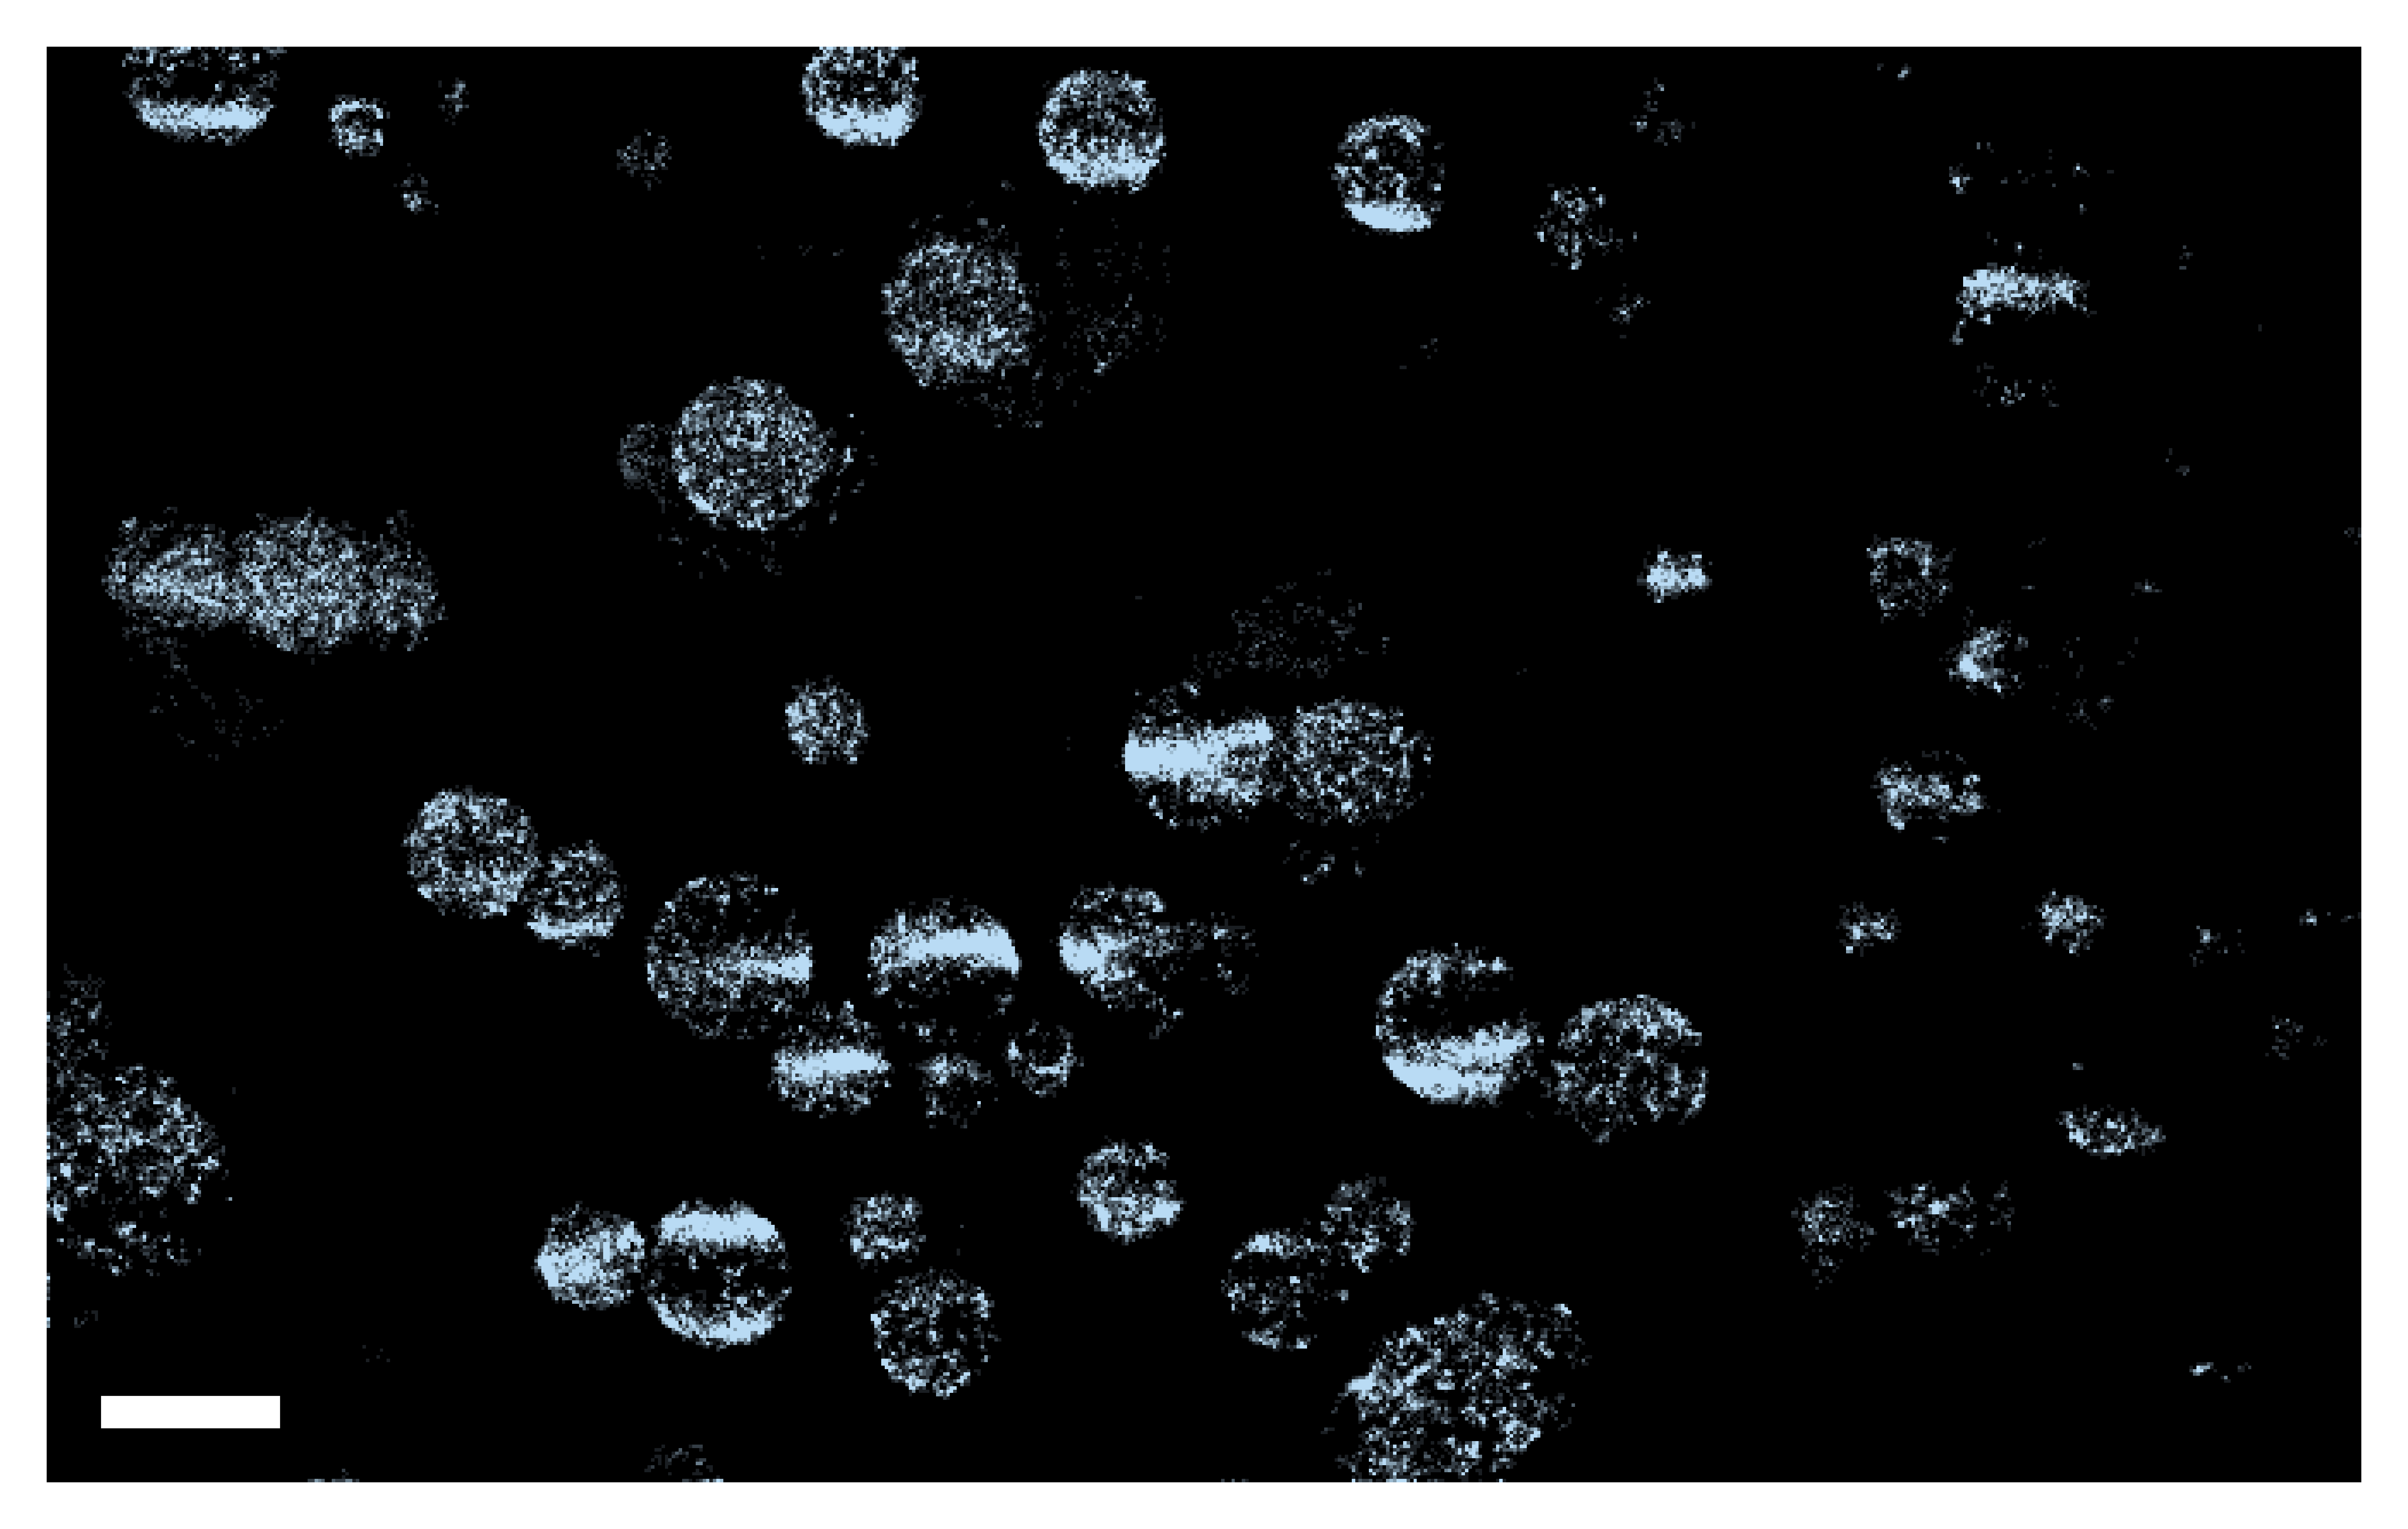

In [5]:
scale_bar_offset = 20

plt.figure(dpi=1200)
# PAINT
plt.imshow(
    img_PAINT,
    cmap=cmap,
    vmin=0,
    vmax=7,
    resample=False,
)
# scale bar
plt.plot(
    [scale_bar_offset, scale_bar_offset + scalebar_length_pxl],
    [scale_bar_offset, scale_bar_offset],
    "-",
    color=scalebar_color,
    lw=5,
)
plt.gca().invert_yaxis()
plt.axis("scaled")
plt.axis("off")
fname_save = fname[:-4] + "-PAINT_overview.png"
plt.savefig(fname_save, bbox_inches="tight", format="png", dpi=1200)
plt.show()

## Zoom in

#### Refernce plot

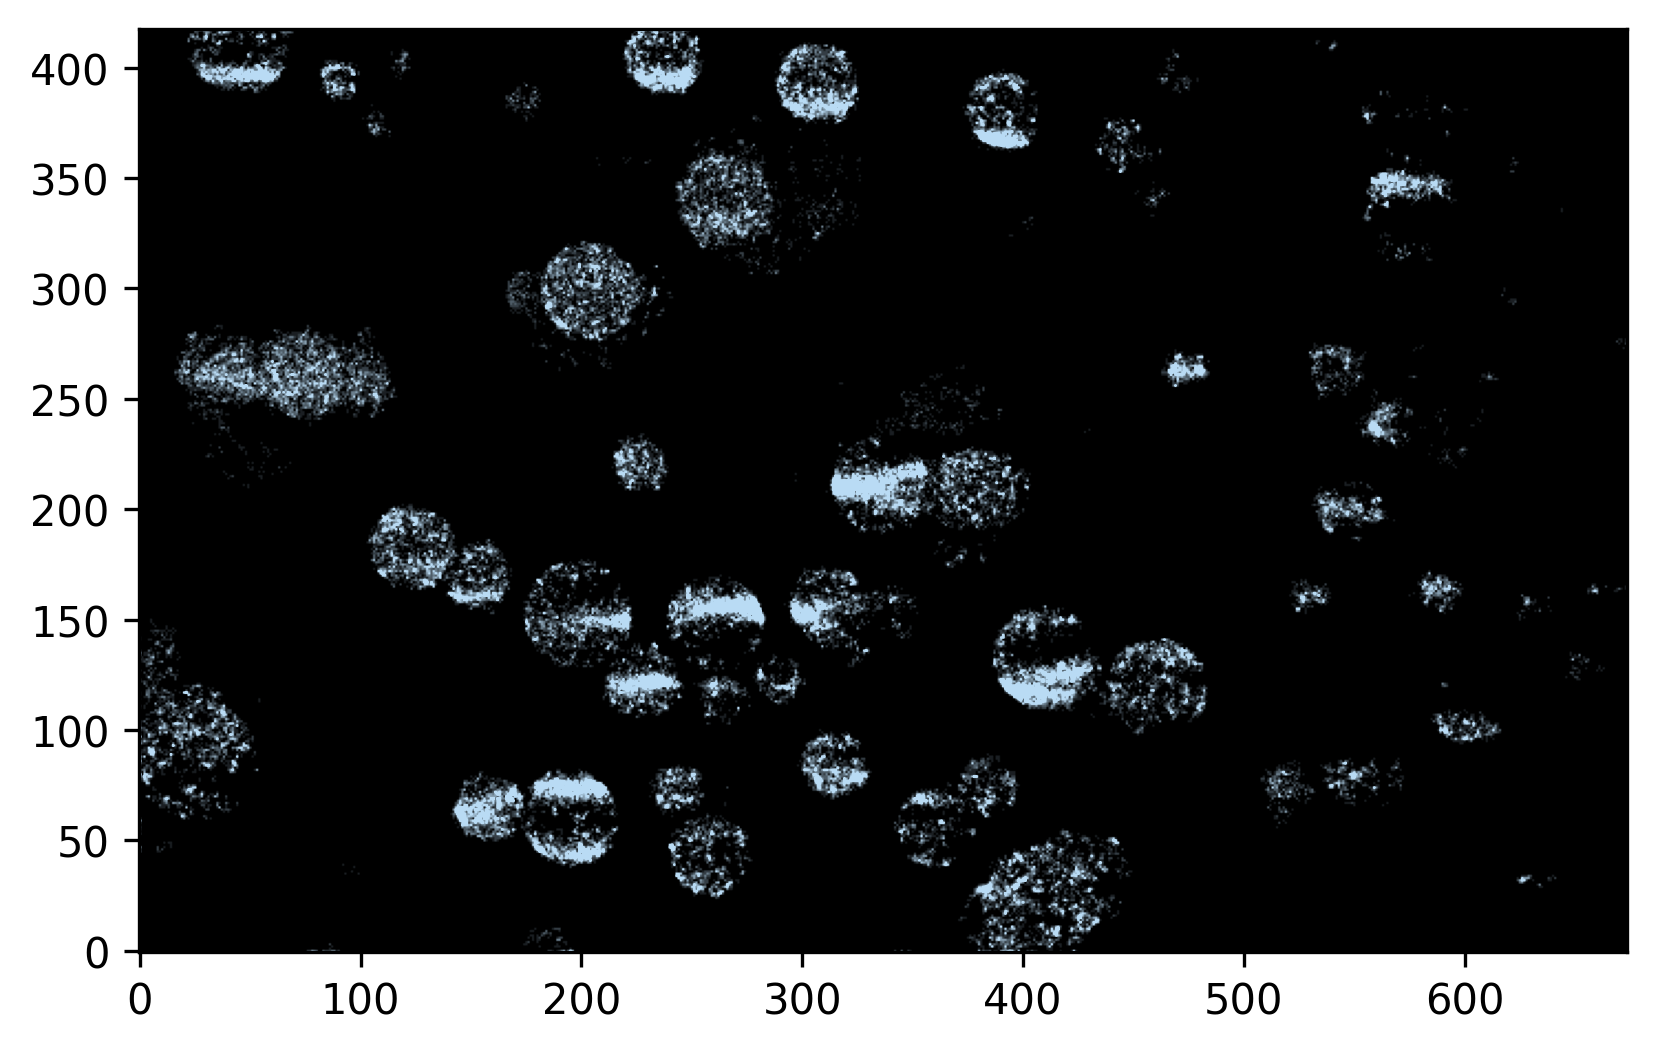

In [6]:
plt.figure(dpi=300)
# PAINT
plt.imshow(
    img_PAINT,
    cmap=cmap,
    vmin=0,
    vmax=7,
    resample=False,
)
plt.gca().invert_yaxis()
plt.axis("scaled")
plt.show()

#### test zoom in

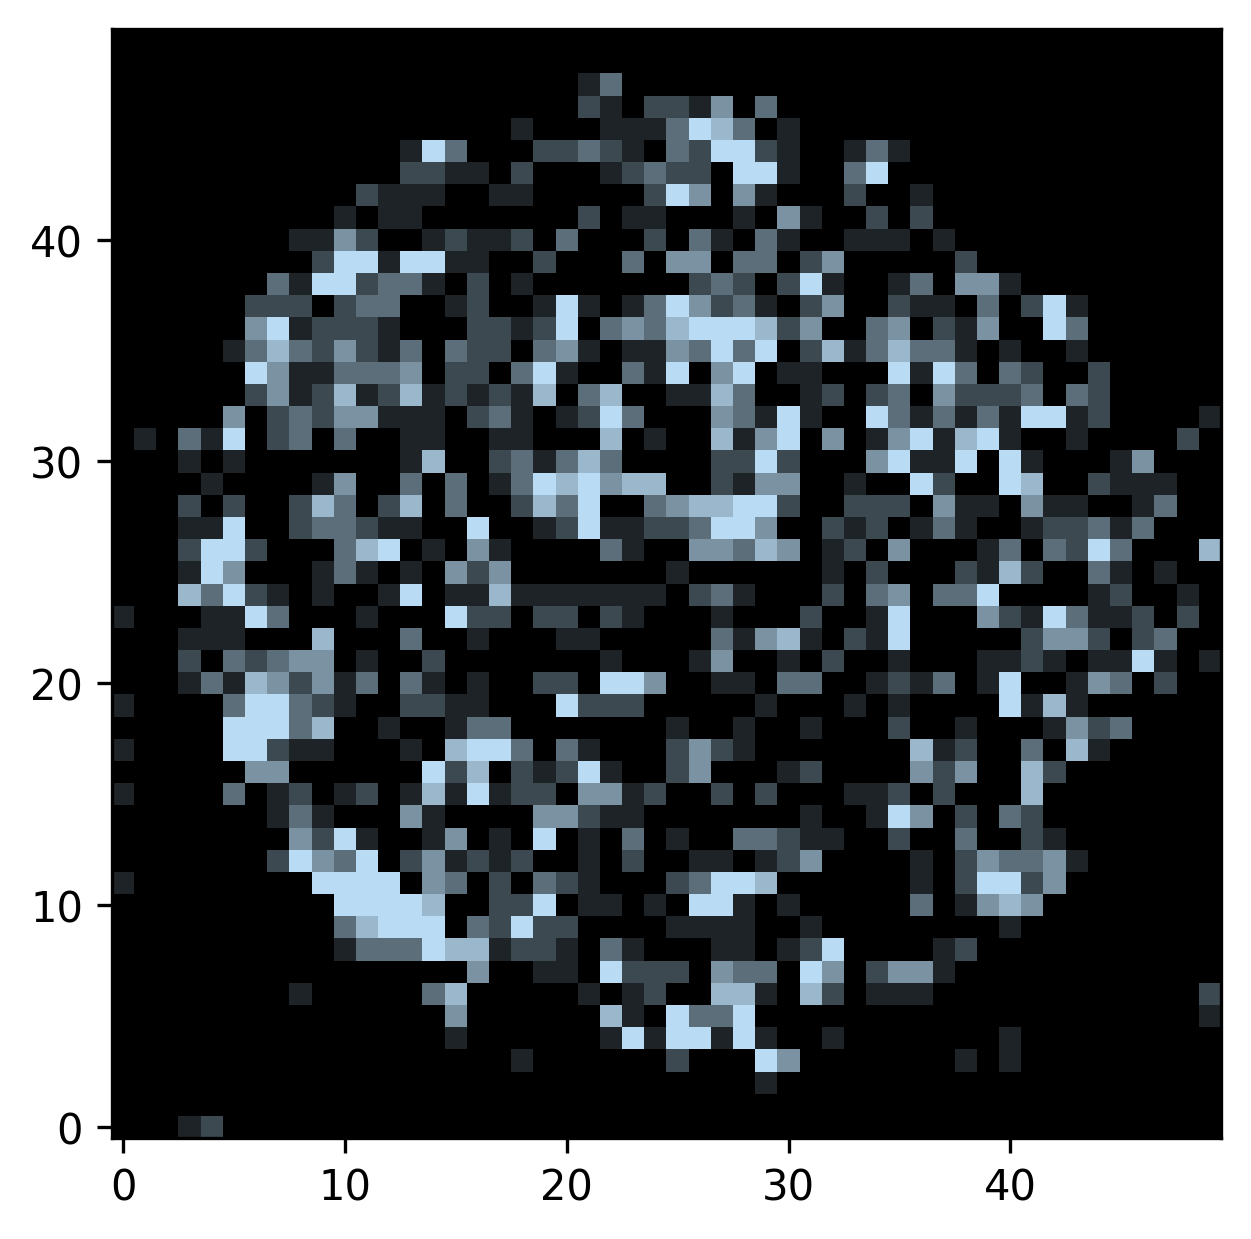

In [7]:
plt.figure(dpi=300)
# PAINT
plt.imshow(
    # img_PAINT[62:122, 105:165],  # for 500pMFOV1-1
    # img_PAINT[22:67, 150:195], # for 500pMFOV1-2
    img_PAINT[274:324, 179:229],  # for 50pMFOV2
    cmap=cmap,
    vmin=1,
    vmax=7,
    resample=False,
)
plt.gca().invert_yaxis()
plt.axis("scaled")
plt.show()

#### real plot

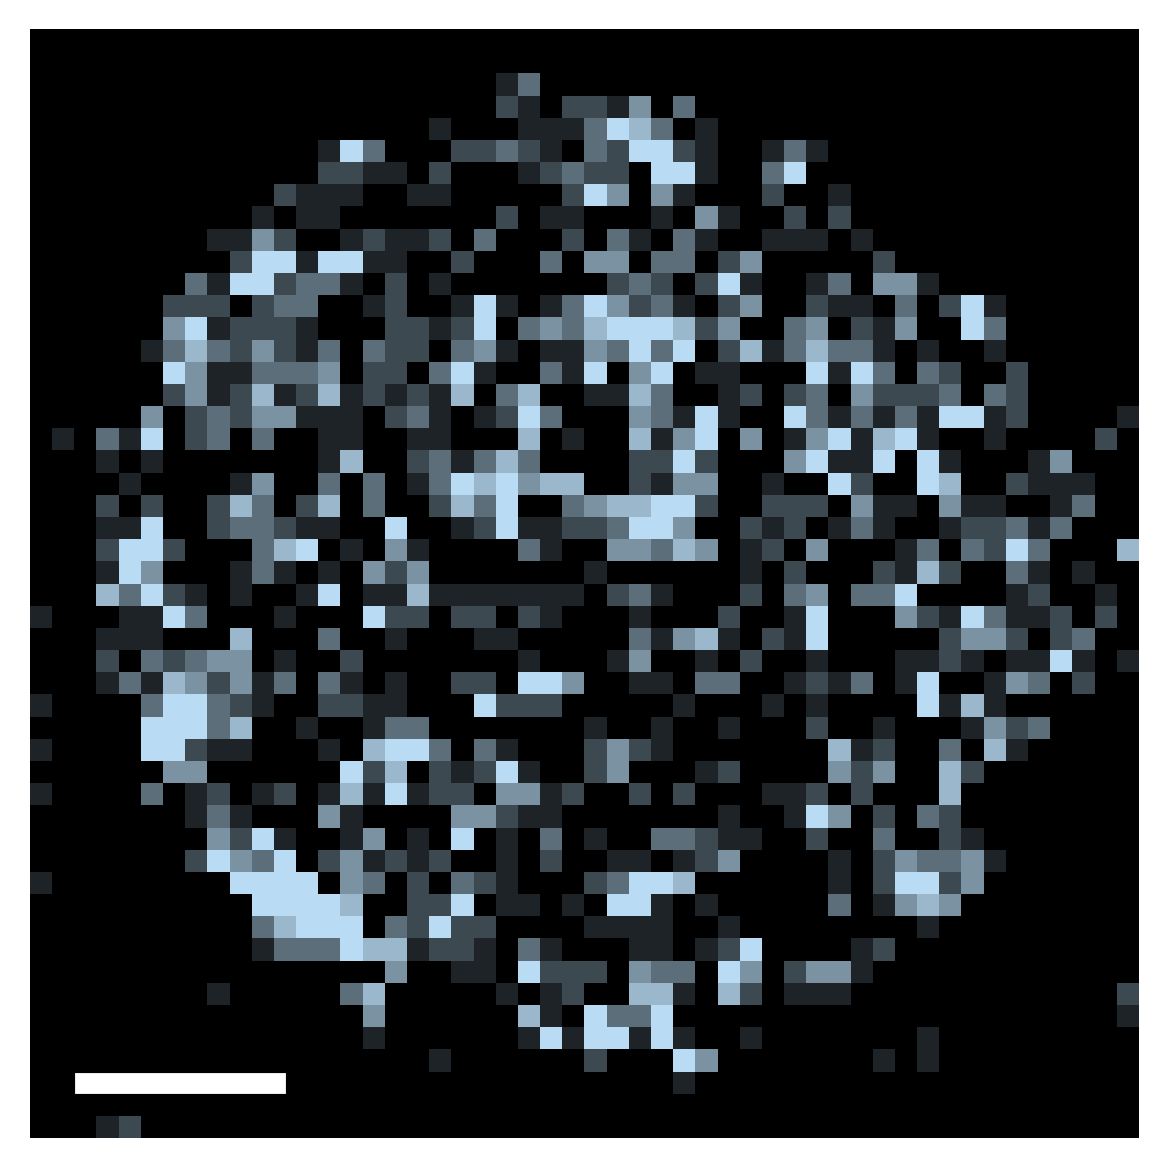

In [8]:
plt.figure(dpi=300)
# PAINT
plt.imshow(
    img_PAINT[274:324, 179:229],
    cmap=cmap,
    vmin=1,
    vmax=7,
    resample=False,
)
# scale bar
scale_bar_offset = 2
scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um * scaling_factor / um_per_pixel
plt.plot(
    [scale_bar_offset, scale_bar_offset + scalebar_length_pxl],
    [scale_bar_offset, scale_bar_offset],
    "-",
    color=scalebar_color,
    lw=5,
)
plt.gca().invert_yaxis()
plt.axis("scaled")
plt.axis("off")
fname_save = fname[:-4] + "-PAINT_overview_zoomed_in.png"
plt.savefig(fname_save, bbox_inches="tight", format="png", dpi=1200)
plt.show()

#### real plot zoom in trajectory

Output()

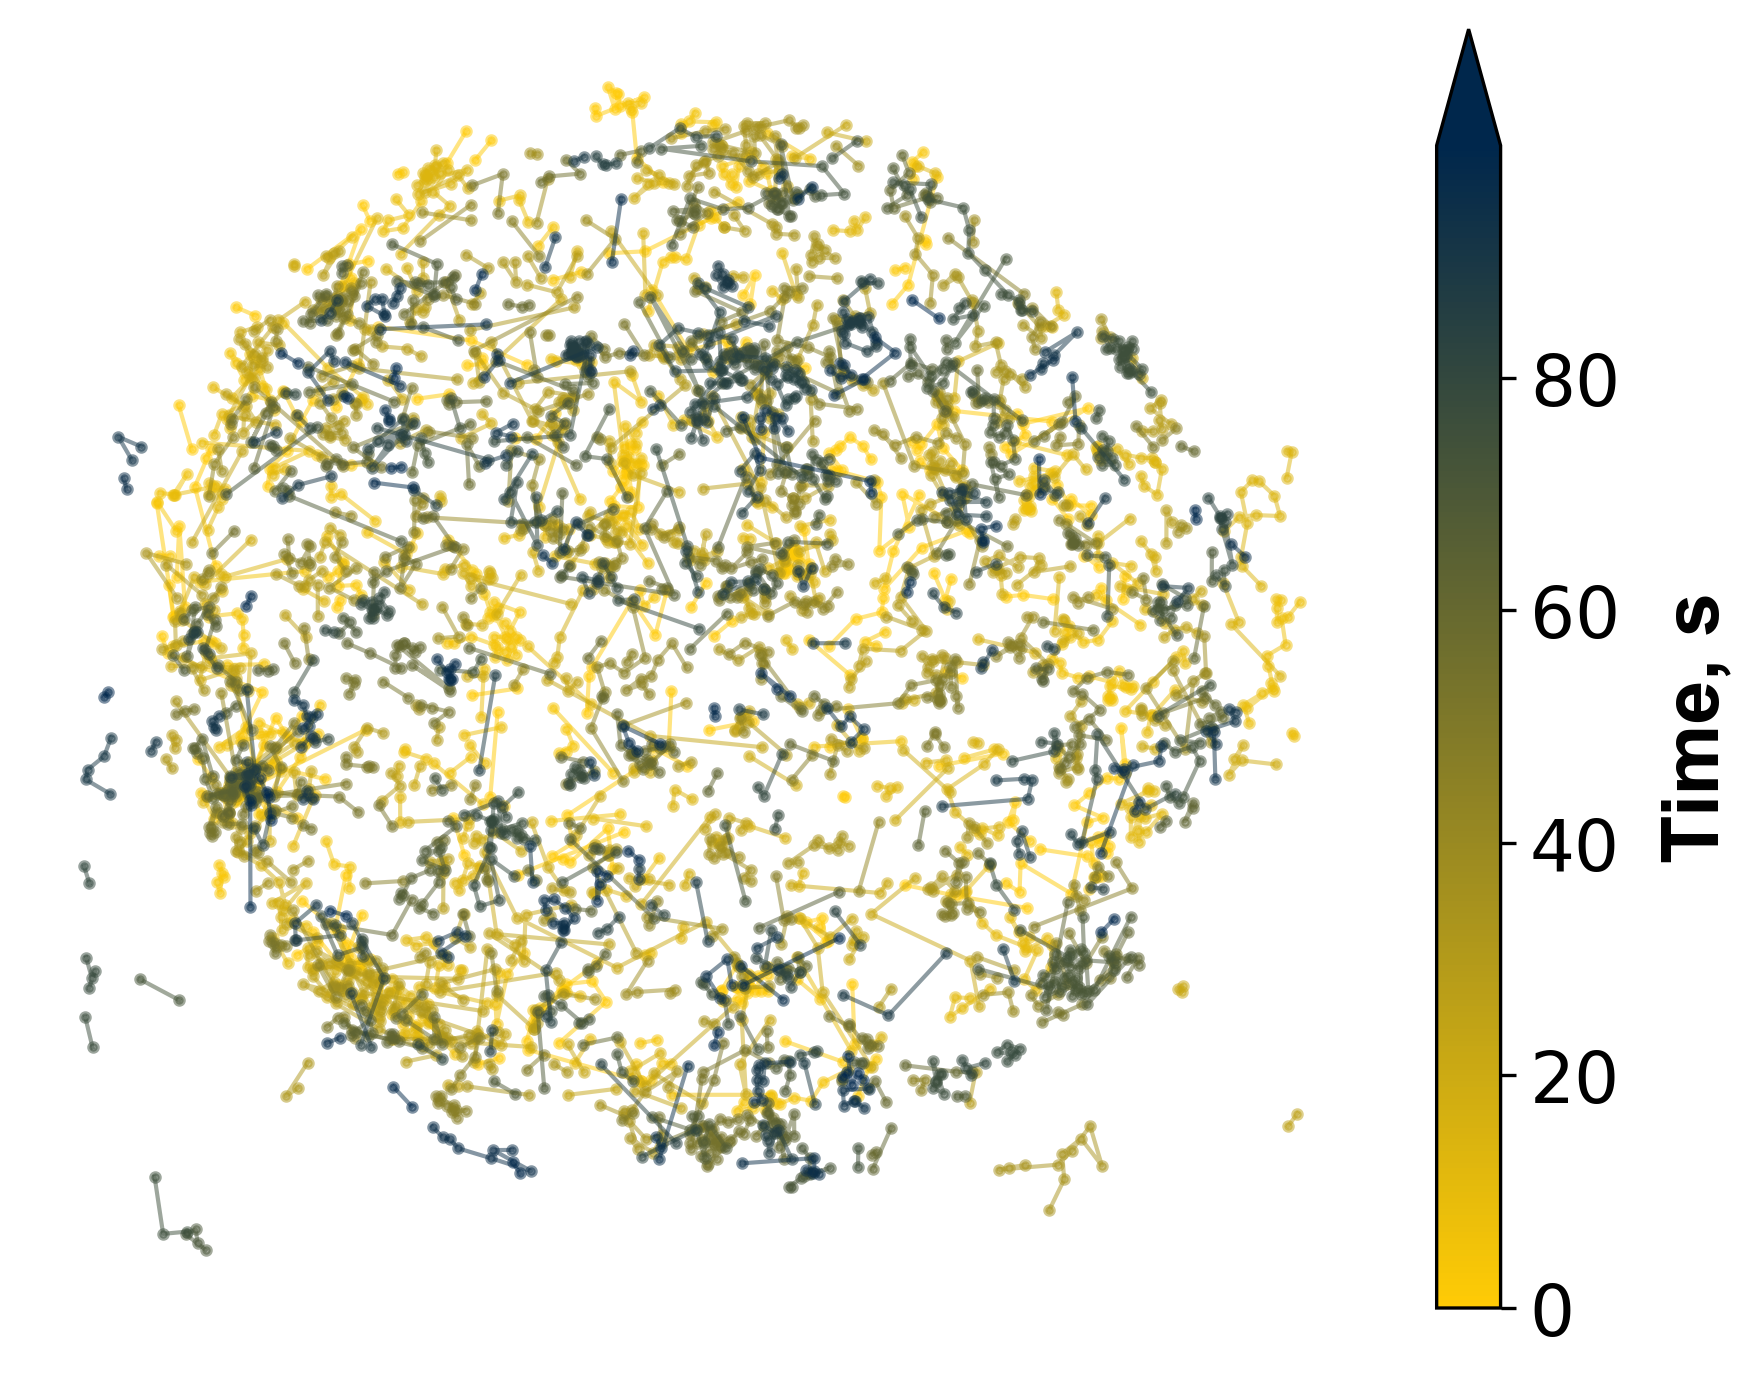

In [10]:
cmap_color_end = "#00274c"
cmap_color_start = "#ffcb05"
cmap_name = "maize2blue"
cmap_tracks = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
    N=200,
)

zoom_in_x = (274, 324)
zoom_in_y = (179, 229)
trackIDs = sorted(df["trackID"].unique())
s_per_frame = 0.1
video_length = (df["t"].max() - df["t"].min()) * s_per_frame

plt.figure(dpi=300)
for idx in track(trackIDs):
    df_current = df[df["trackID"] == idx]
    x = df_current["x"].to_numpy(float)
    y = df_current["y"].to_numpy(float)
    t = df_current["t"].to_numpy(float) * s_per_frame
    if (
        (x.min() > zoom_in_x[0])
        & (x.max() < zoom_in_x[1])
        & (y.min() > zoom_in_y[0])
        & (y.max() < zoom_in_y[1])
    ):
        plt.plot(
            y,
            x,
            "-o",
            color=cmap_tracks(np.mean(t) / video_length),
            linewidth=1,
            markersize=2,
            alpha=0.5,
        )

# plot color bar for time
cbar = plt.colorbar(
    cm.ScalarMappable(
        norm=clr.Normalize(0, video_length * s_per_frame), cmap=cmap_tracks
    ),
    ax=plt.gca(),
    orientation="vertical",
    pad=0.05,
    drawedges=False,
    ticks=[0, 20, 40, 60, 80],
    extendfrac=0.1,
    extend="max",
)
cbar.set_label(
    label="Time, s",
    weight="bold",
    fontsize=19,
    labelpad=10,
    family="Arial",
)
cbar.ax.tick_params(labelsize=17)

# scale bar
scale_bar_offset = 0
scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um * scaling_factor / um_per_pixel
plt.xlim(zoom_in_x[0], zoom_in_x[1])
plt.ylim(zoom_in_y[0], zoom_in_y[1])

plt.tight_layout()
plt.axis("equal")
plt.axis("off")
fname_save = fname[:-4] + "-tracks_zoomed_in.png"
plt.savefig(fname_save, bbox_inches="tight", format="png", dpi=1200)
plt.show()

## Step size plot

In [ ]:
img_stepsize, _, _ = np.histogram2d(
    x=df["x"] * scaling_factor,
    y=df["y"] * scaling_factor,
    bins=(xedges, yedges),
)

In [21]:
# calculate all step size
nm_per_pxl = 117
trackIDs = sorted(df["trackID"].unique())
lst_mid_x = []
lst_mid_y = []
lst_stepsize = []
for idx in track(trackIDs):
    df_current = df[df["trackID"] == idx]
    xs = df_current["x"].to_numpy(float)
    ys = df_current["y"].to_numpy(float)
    ts = df_current["t"].to_numpy(float)
    mid_xs = (xs[1:] + xs[:-1]) / 2
    mid_ys = (ys[1:] + ys[:-1]) / 2
    steps = np.sqrt((xs[1:] - xs[:-1]) ** 2 + (ys[1:] - ys[:-1]) ** 2) * nm_per_pxl
    lst_mid_x.extend(mid_xs)
    lst_mid_y.extend(mid_ys)
    lst_stepsize.extend(steps)

df_all_steps = pd.DataFrame(
    {
        "mid_x": lst_mid_x,
        "mid_y": lst_mid_y,
        "stepsize": lst_stepsize,
    },
    dtype=float,
)

Output()

In [ ]:
# put them in grid, calculate mean
img_stepsize = np.zeros_like(img_PAINT)
for x in track(range(img_stepsize.shape[0])):
    for y in range(img_stepsize.shape[1]):
        df_current = df_all_steps[
            df_all_steps['mid_x'].between(x,x+1) & df_all_steps['mid_y'].between(y,y+1)
        ]
        df1 = df_all_steps[df_all_steps["mid_x"] >= x]
        df2 = df1[df1["mid_x"] <= x + 1]
        df3 = df2[df2["mid_y"] >= y]
        df4 = df3[df3["mid_y"] <= y + 1]
        mean_stepsize = df4['stepsize'].mean()
        img_stepsize[x,y] = mean_stepsize

In [25]:
img_stepsize.shape[0]

418